In [1]:
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from transformers import BertTokenizer
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.optim import AdamW
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)

import time
import matplotlib.pyplot as plt
from collections import defaultdict
import os

import torch
import argparse
from transformers import BertTokenizer, BertModel
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import DataLoader
import argparse

2026-02-21 16:16:05.497911: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771690565.672863      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771690565.723619      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [ ]:
def main(args):
    torch.manual_seed(args.seed)
    torch.cuda.empty_cache()
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


    file_map = {
            "gab": '/kaggle/input/datasets/jonnielmirafuentes/test-set/Mistral_Rationales_file_GAB_dataset(90-10).csv',
            "twitter": '/kaggle/input/datasets/jonnielmirafuentes/final-data/Mistral_Rationales_file_Twitter_dataset(85-15).csv',
            "reddit": '/kaggle/input/datasets/jonnielmirafuentes/final-data/Mistral_Rationales_file_REDDIT_dataset(85-15).csv',
            "youtube": '/kaggle/input/datasets/jonnielmirafuentes/final-data/Mistral_Rationales_file_YOUTUBE_dataset(85-15).csv',
            "implicit": '/kaggle/input/datasets/jonnielmirafuentes/final-data/Mistral_Rationales_file_IMPLICIT_dataset(85-15).csv'
        }

    file_path = file_map[args.dataset]
    df = pd.read_csv(file_path)
    train_df = df[df['exp_split'] == 'train']
    test_df = df[df['exp_split'] == 'test']

    print("Train df: ", len(train_df))
    print("Test_df: ", len(test_df))

    import gc
    gc.collect()

    bert_model_name = "bert-base-uncased"
    tokenizer = BertTokenizer.from_pretrained("GroNLP/hateBERT")
    tokenizer_bert = AutoTokenizer.from_pretrained(bert_model_name)

    class AdditionalCustomDataset(Dataset):
        def __init__(self, texts, labels, additional_texts, tokenizer, bert_tokenizer, max_length):
            self.texts = texts
            self.labels = labels
            self.additional_texts = additional_texts
            self.tokenizer = tokenizer
            self.bert_tokenizer = bert_tokenizer
            self.max_length = max_length

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            texts = self.texts[idx]
            additional_texts = self.additional_texts[idx]
            labels = self.labels[idx]
            encoding = self.tokenizer(texts, max_length=self.max_length, truncation=True, padding='max_length', return_tensors='pt')
            additional_encoding = self.bert_tokenizer(additional_texts, max_length=self.max_length, truncation=True, padding='max_length', return_tensors='pt')
            original_input_ids = encoding['input_ids'].squeeze()
            additional_input_ids = additional_encoding['input_ids'].squeeze()
            input_ids = torch.cat((encoding["input_ids"], additional_encoding["input_ids"]), dim=1)
            original_attention_mask = encoding['attention_mask'].squeeze()
            additional_attention_mask = additional_encoding['attention_mask'].squeeze()
            attention_mask = torch.cat((encoding["attention_mask"], additional_encoding["attention_mask"]), dim=1)
            labels = labels
            return original_input_ids, original_attention_mask, additional_input_ids, additional_attention_mask, labels

    if args.dataset=='implicit':
        train_text, val_texts, train_labels, val_labels = train_test_split(train_df['post'].tolist(),train_df['label'].tolist(), test_size = 0.2)
    else:
        train_text, val_texts, train_labels, val_labels = train_test_split(train_df['text'].tolist(),train_df['label'].tolist(), test_size = 0.2)
    
    add_train_text, add_val_texts, add_train_labels, add_val_labels = train_test_split(train_df['Mistral_Rationales'].tolist(),train_df['label'].tolist(), test_size = 0.2)

    train_dataset = AdditionalCustomDataset(train_text, train_labels, add_train_text, tokenizer, tokenizer_bert, max_length = 512)
    val_dataset = AdditionalCustomDataset(val_texts, val_labels, add_val_texts, tokenizer, tokenizer_bert, max_length = 512)

    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    class ProjectionMLP(nn.Module):
        def __init__(self, input_size, output_size):
            super(ProjectionMLP, self).__init__()
            self.layers = nn.Sequential(
                nn.Linear(input_size, output_size),
                nn.ReLU(),
                nn.Linear(output_size, 2)
            )

        def forward(self, x):
            return self.layers(x)


    class ConcatModel(nn.Module):
        def __init__(self, hatebert_model, additional_model, projection_mlp, freeze_additional_model=True):
            super(ConcatModel, self).__init__()
            self.hatebert_model = hatebert_model
            self.additional_model = additional_model
            self.projection_mlp = projection_mlp

            if freeze_additional_model:
                for param in self.additional_model.parameters():
                    param.requires_grad = False

        def forward(self, input_ids, attention_mask, additional_input_ids, additional_attention_mask):
            hatebert_outputs = self.hatebert_model(input_ids=input_ids, attention_mask=attention_mask)
            hatebert_embeddings = hatebert_outputs.last_hidden_state[:, 0, :]
            hatebert_embeddings = torch.nn.LayerNorm(hatebert_embeddings.size()[1:]).to(device)(hatebert_embeddings.to(device)).to(device)

            additional_outputs = self.additional_model(input_ids=additional_input_ids, attention_mask=additional_attention_mask)
            additional_embeddings = additional_outputs.last_hidden_state[:, 0, :]
            additional_embeddings = torch.nn.LayerNorm(additional_embeddings.size()[1:]).to(device)(additional_embeddings.to(device)).to(device)

            concatenated_embeddings = torch.cat((hatebert_embeddings, additional_embeddings), dim=1).to(device)
            projected_embeddings = self.projection_mlp(concatenated_embeddings).to(device)

            return projected_embeddings



    hatebert_model = BertModel.from_pretrained("GroNLP/HateBERT").to(device)
    additional_model = BertModel.from_pretrained("bert-base-uncased").to(device)
    projection_mlp = ProjectionMLP(input_size=1536, output_size=512).to(device)

    freeze_flag = args.freeze.lower() if args.freeze else 'yes'
    
    if freeze_flag == 'yes':
        concat_model = ConcatModel(hatebert_model=hatebert_model,
                                   additional_model=additional_model,
                                   projection_mlp=projection_mlp,
                                   freeze_additional_model=True)
    elif freeze_flag == 'no':
        concat_model = ConcatModel(hatebert_model=hatebert_model,
                                   additional_model=additional_model,
                                   projection_mlp=projection_mlp,
                                   freeze_additional_model=False)
    else:
        raise ValueError(f"Invalid freeze option: {args.freeze}. Must be 'yes' or 'no'.")

    concat_model = concat_model.to(device)

    optimizer = AdamW(concat_model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss().to(device)

    from tqdm import tqdm
    os.makedirs("/kaggle/working/models", exist_ok=True)
    
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_acc": [],
        "val_precision": [],
        "val_recall": [],
        "val_f1": [],
        "epoch_time": [],
        "train_throughput": [],
        "val_confidence_mean": [],
        "val_confidence_std": [],
        "gpu_memory_mb": [],
        "val_loss": []
    }
    
    all_epoch_val_confidences = []
    
    # ================= EARLY STOPPING CONFIG (BASED ON LOSS) =================
    early_stop_patience = args.patience if hasattr(args, "patience") else 3
    early_stop_counter = 0
    best_val_loss = float("inf")  # Changed: track best validation loss
    best_epoch = -1
    best_val_f1 = 0.0
    
    best_model_path = (
        f"/kaggle/working/models/"
        f"best_concat_model_{args.dataset}_seed{args.seed}.pth"
    )


    for epoch in range(args.num_epochs):
        epoch_val_confidences = []
        epoch_start_time = time.time()
        samples_seen = 0
        
        concat_model.train()
        train_losses = []
        train_accuracy = 0
        train_epoch_size = 0

        with tqdm(train_dataloader, desc=f'Epoch {epoch + 1}', dynamic_ncols=True) as loop:
            for batch in loop:
                input_ids, attention_mask, additional_input_ids, additional_attention_mask, labels = batch
                samples_seen += labels.size(0)
                
                if torch.cuda.is_available():
                    input_ids = input_ids.to(device)
                    attention_mask = attention_mask.to(device)
                    additional_input_ids = additional_input_ids.to(device)
                    additional_attention_mask = additional_attention_mask.to(device)
                    labels = labels.to(device)

                optimizer.zero_grad()
                outputs = concat_model(input_ids=input_ids, attention_mask=attention_mask, additional_input_ids=additional_input_ids, additional_attention_mask=additional_attention_mask)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_losses.append(loss.item())
                predictions = torch.argmax(outputs, dim=1)
                train_accuracy += (predictions == labels).sum().item()
                train_epoch_size += len(labels)

        epoch_train_time = time.time() - epoch_start_time
        train_throughput = samples_seen / epoch_train_time

        concat_model.eval()
        val_predictions = []
        val_labels = []
        val_loss = 0.0
        num_batches = 0
        
        with torch.no_grad(), tqdm(val_dataloader, desc='Validation', dynamic_ncols=True) as loop:
            for batch in loop:
                input_ids, attention_mask, additional_input_ids, additional_attention_mask, labels = batch

                if torch.cuda.is_available():
                    input_ids = input_ids.to(device)
                    attention_mask = attention_mask.to(device)
                    additional_input_ids = additional_input_ids.to(device)
                    additional_attention_mask = additional_attention_mask.to(device)
                    labels = labels.to(device)

                outputs = concat_model(input_ids=input_ids, attention_mask=attention_mask, additional_input_ids=additional_input_ids, additional_attention_mask=additional_attention_mask)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                num_batches += 1

                probs = torch.softmax(outputs, dim=1)
                confidences, preds = torch.max(probs, dim=1)
                epoch_val_confidences.extend(confidences.cpu().numpy())

                sm = nn.Softmax(dim=1)
                predictions = torch.argmax(sm(outputs), dim=1)
                val_predictions.extend(predictions.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

            val_loss /= num_batches
            
        accuracy = accuracy_score(val_labels, val_predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(
            val_labels, val_predictions, average='weighted'
        )
        
        # ================= EARLY STOPPING CHECK (BASED ON LOSS) =================
        if f1 > best_val_f1:  # Changed: check if F1 improved
            best_val_f1 = f1  # Changed: update best F1
            best_epoch = epoch + 1
            early_stop_counter = 0
        
            torch.save(concat_model.state_dict(), best_model_path)
            print(f"  ✅ New best model saved (Epoch {epoch + 1}, Val Loss={val_loss:.4f}, F1={f1:.4f})")
        
        else:
            early_stop_counter += 1
            print(f"  ⏳ No improvement in F-1. EarlyStop counter: {early_stop_counter}/{early_stop_patience}")
        
        if early_stop_counter >= early_stop_patience:
            print(
                f"\n🛑 Early stopping triggered at epoch {epoch + 1}. "
                f"Best epoch: {best_epoch} (Val Loss={best_val_loss:.4f})"
            )
            break
        
        print(f"Epoch {epoch + 1}:")
        print(f"  Validation Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-score: {f1:.4f}")
        print(f"  Avg. Train Loss: {sum(train_losses) / len(train_losses):.4f}")
        print(f"  Validation Loss: {val_loss:.4f}")
        epoch_time = time.time() - epoch_start_time
        conf_mean = np.mean(epoch_val_confidences)
        conf_std = np.std(epoch_val_confidences)

        history["train_loss"].append(np.mean(train_losses))
        history["train_acc"].append(train_accuracy / train_epoch_size)
        history["val_acc"].append(accuracy)
        history["val_precision"].append(precision)
        history["val_recall"].append(recall)
        history["val_f1"].append(f1)
        history["epoch_time"].append(epoch_time)
        history["train_throughput"].append(train_throughput)
        history["val_confidence_mean"].append(conf_mean)
        history["val_confidence_std"].append(conf_std)
        history["val_loss"].append(val_loss)
        
        if torch.cuda.is_available():
            history["gpu_memory_mb"].append(
                torch.cuda.max_memory_allocated() / 1024**2
            )
            torch.cuda.reset_peak_memory_stats()
        
        print(f"  Epoch Time (s): {epoch_time:.2f}")
        print(f"  Throughput (samples/sec): {train_throughput:.2f}")
        print(f"  Val Confidence Mean: {conf_mean:.4f} ± {conf_std:.4f}")
        
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(10, 4))
    plt.plot(epochs, history["train_loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss per Epoch")
    plt.show()
    
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per Epoch")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, history["val_precision"], label="Precision")
    plt.plot(epochs, history["val_recall"], label="Recall")
    plt.plot(epochs, history["val_f1"], label="F1-score")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Validation Metrics per Epoch")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 4))
    mean = np.array(history["val_confidence_mean"])
    std = np.array(history["val_confidence_std"])
    plt.plot(epochs, mean, label="Mean Confidence")
    plt.fill_between(epochs, mean - std, mean + std, alpha=0.3)
    plt.xlabel("Epoch")
    plt.ylabel("Confidence")
    plt.title("Validation Confidence Scores")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, history["epoch_time"], label="Epoch Time (s)")
    plt.xlabel("Epoch")
    plt.ylabel("Seconds")
    plt.title("Training Time per Epoch")
    plt.legend()
    plt.show()
    
    if torch.cuda.is_available():
        plt.figure(figsize=(10, 4))
        plt.plot(epochs, history["gpu_memory_mb"])
        plt.xlabel("Epoch")
        plt.ylabel("MB")
        plt.title("Peak GPU Memory Usage")
        plt.show()

    model_save_path = (
        f"/kaggle/working/models/"
        f"concat_model_{args.dataset}_baseline_epochs{args.num_epochs}_seed{args.seed}.pth"
    )

    model_save_path_no_check = (
        f"/kaggle/working/models/"
        f"concat_model_{args.dataset}_baseline_non_checkpoint_epochs{args.num_epochs}_seed{args.seed}.pth"
    )

    concat_model.load_state_dict(torch.load(best_model_path))
    print(f"\n✅ Loaded best model from Epoch {best_epoch} for testing")

    torch.save(concat_model.state_dict(), model_save_path_no_check)
    
    checkpoint = {
        "model_state_dict": concat_model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": args.num_epochs,
        "dataset": args.dataset,
        "freeze": args.freeze,
        "seed": args.seed,
        "history": history
    }
    
    torch.save(checkpoint, model_save_path)
    print(f"\n✅ Model checkpoint saved to: {model_save_path}")

    if args.dataset=='implicit':
        test_texts = test_df['post'].tolist()
    else:
        test_texts = test_df['text'].tolist()

    add_test_texts = test_df['Mistral_Rationales'].tolist()
    test_labels = test_df['label'].tolist()

    test_dataset = AdditionalCustomDataset(test_texts, test_labels, add_test_texts, tokenizer, tokenizer_bert, max_length = 512)
    test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)

    concat_model.eval()
    test_predictions = []
    test_labels_list = []
    test_confidences = []
    samples_seen = 0
    test_start_time = time.time()
    
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
    
    with torch.no_grad(), tqdm(test_dataloader, desc='Testing', dynamic_ncols=True) as loop:
        for batch in loop:
            input_ids, attention_mask, additional_input_ids, additional_attention_mask, labels = batch
            batch_size = labels.size(0)
            samples_seen += batch_size

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            additional_input_ids = additional_input_ids.to(device)
            additional_attention_mask = additional_attention_mask.to(device)
            labels = labels.to(device)
    
            outputs = concat_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                additional_input_ids=additional_input_ids,
                additional_attention_mask=additional_attention_mask
            )
    
            probs = torch.softmax(outputs, dim=1)
            confidences, preds = torch.max(probs, dim=1)
            test_confidences.extend(confidences.cpu().numpy())
            test_predictions.extend(preds.cpu().numpy())
            test_labels_list.extend(labels.cpu().numpy())
    
    test_time = time.time() - test_start_time
    test_throughput = samples_seen / test_time
    
    accuracy = accuracy_score(test_labels_list, test_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        test_labels_list, test_predictions, average='weighted'
    )
    conf_mean = np.mean(test_confidences)
    conf_std = np.std(test_confidences)
    cm = confusion_matrix(test_labels_list, test_predictions)
    gpu_memory_mb = torch.cuda.max_memory_allocated() / 1024**2 if torch.cuda.is_available() else 0
    
    print("\n================= FINAL TEST RESULTS =================")
    print(f"Dataset: {args.dataset}, Seed: {args.seed}, Freeze: {args.freeze}, Epochs: {args.num_epochs}")
    print(f"Test Accuracy : {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall   : {recall:.4f}")
    print(f"Test F1-score : {f1:.4f}")
    print(f"Test Confidence Mean ± Std: {conf_mean:.4f} ± {conf_std:.4f}")
    print(f"Test Time (s) : {test_time:.2f}")
    print(f"Throughput (samples/sec) : {test_throughput:.2f}")
    print(f"Peak GPU Memory (MB) : {gpu_memory_mb:.2f}")
    print("\nClassification Report:")
    print(classification_report(test_labels_list, test_predictions))
    print("\nConfusion Matrix:")
    print(cm)
    plt.figure(figsize=(6, 5))

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    plt.title("Confusion Matrix")
    plt.colorbar()

    classes = ["Non-Hate", "Hate"]

    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    threshold = cm.max() / 2.0

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i,
                format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                fontsize=12
            )

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix Heatmap (Blue)")

    plt.tight_layout()
    plt.show()
    print("======================================================")


Train df:  31589
Test_df:  5575


tokenizer_config.json:   0%|          | 0.00/151 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Validation: 100%|██████████| 790/790 [03:13<00:00,  4.08it/s]


  ✅ New best model saved (Epoch 1, Val Loss=0.2239, F1=0.9151)
Epoch 1:
  Validation Accuracy: 0.9152
  Precision: 0.9151
  Recall: 0.9152
  F1-score: 0.9151
  Avg. Train Loss: 0.3222
  Validation Loss: 0.2239
  Epoch Time (s): 2438.19
  Throughput (samples/sec): 11.27
  Val Confidence Mean: 0.9338 ± 0.1098


Validation: 100%|██████████| 790/790 [03:13<00:00,  4.08it/s]


  ✅ New best model saved (Epoch 2, Val Loss=0.2377, F1=0.9415)
Epoch 2:
  Validation Accuracy: 0.9414
  Precision: 0.9417
  Recall: 0.9414
  F1-score: 0.9415
  Avg. Train Loss: 0.1115
  Validation Loss: 0.2377
  Epoch Time (s): 2442.42
  Throughput (samples/sec): 11.25
  Val Confidence Mean: 0.9827 ± 0.0631


Validation: 100%|██████████| 790/790 [03:14<00:00,  4.07it/s]


  ✅ New best model saved (Epoch 3, Val Loss=0.2597, F1=0.9466)
Epoch 3:
  Validation Accuracy: 0.9465
  Precision: 0.9469
  Recall: 0.9465
  F1-score: 0.9466
  Avg. Train Loss: 0.0488
  Validation Loss: 0.2597
  Epoch Time (s): 2444.28
  Throughput (samples/sec): 11.24
  Val Confidence Mean: 0.9891 ± 0.0497


Validation: 100%|██████████| 790/790 [03:13<00:00,  4.07it/s]


  ⏳ No improvement in F-1. EarlyStop counter: 1/2
Epoch 4:
  Validation Accuracy: 0.9443
  Precision: 0.9444
  Recall: 0.9443
  F1-score: 0.9443
  Avg. Train Loss: 0.0343
  Validation Loss: 0.2626
  Epoch Time (s): 2443.49
  Throughput (samples/sec): 11.23
  Val Confidence Mean: 0.9886 ± 0.0537


Validation: 100%|██████████| 790/790 [03:12<00:00,  4.10it/s]


  ⏳ No improvement in F-1. EarlyStop counter: 2/2

🛑 Early stopping triggered at epoch 5. Best epoch: 3 (Val Loss=inf)


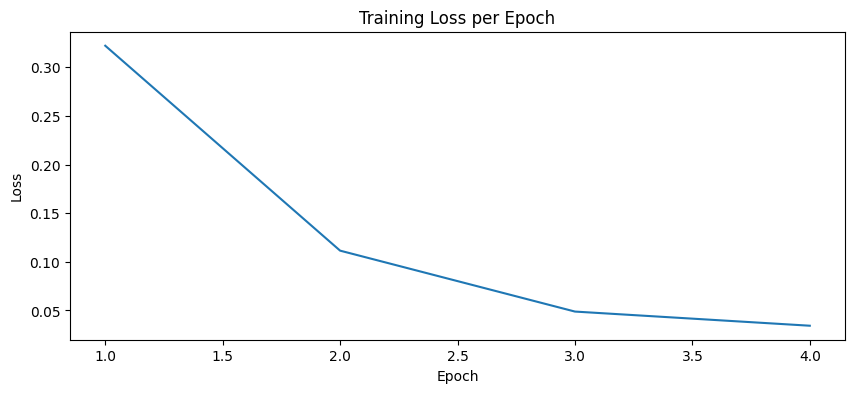

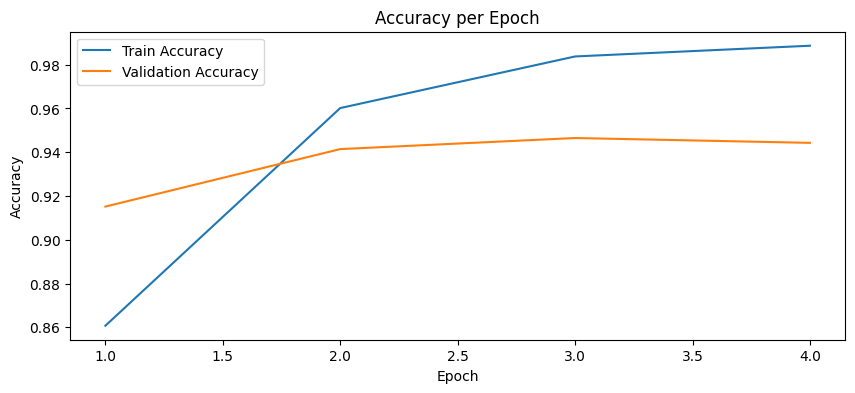

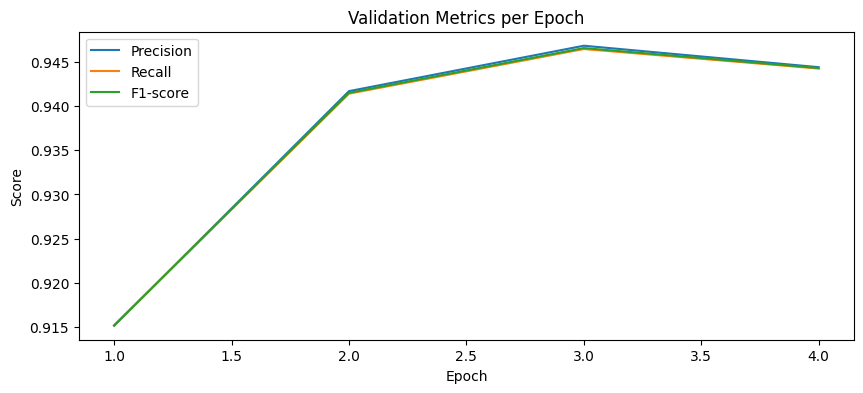

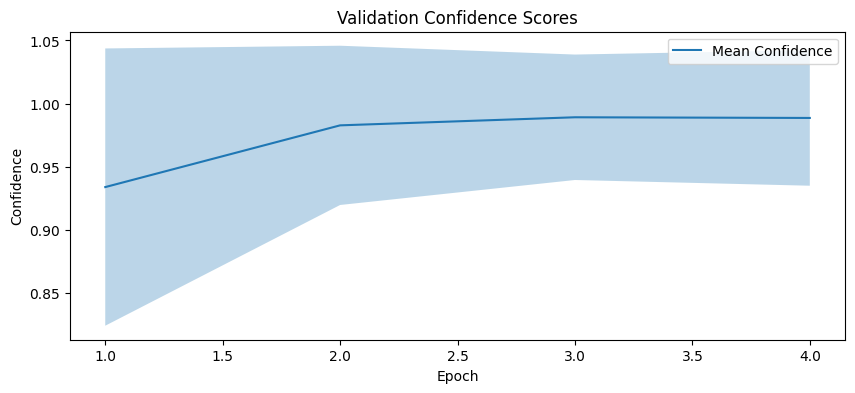

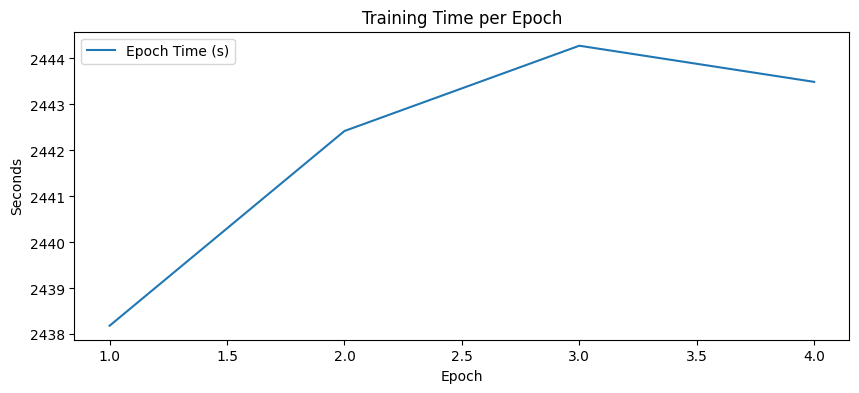

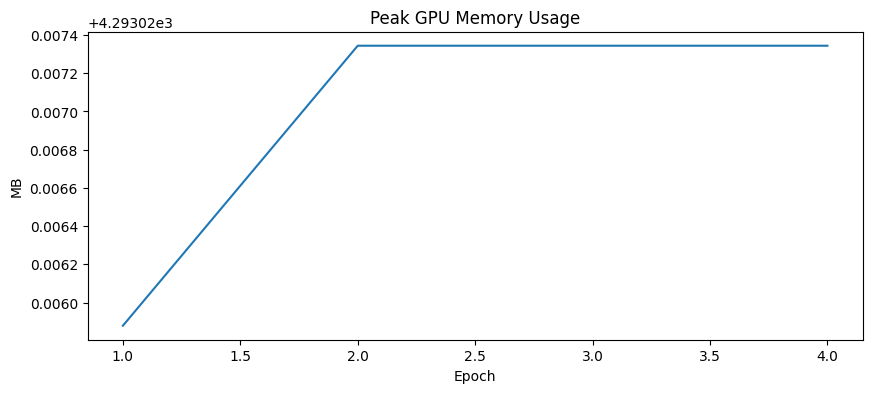


✅ Loaded best model from Epoch 3 for testing

✅ Model checkpoint saved to: /kaggle/working/models/concat_model_reddit_baseline_epochs10_seed42.pth


Testing: 100%|██████████| 2788/2788 [03:18<00:00, 14.07it/s]



================= FINAL TEST RESULTS =================
Dataset: reddit, Seed: 42, Freeze: yes, Epochs: 10
Test Accuracy : 0.9396
Test Precision: 0.9397
Test Recall   : 0.9396
Test F1-score : 0.9396
Test Confidence Mean ± Std: 0.9874 ± 0.0538
Test Time (s) : 198.09
Throughput (samples/sec) : 28.14
Peak GPU Memory (MB) : 2209.56

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3513
           1       0.91      0.92      0.92      2062

    accuracy                           0.94      5575
   macro avg       0.93      0.94      0.94      5575
weighted avg       0.94      0.94      0.94      5575


Confusion Matrix:
[[3336  177]
 [ 160 1902]]


AttributeError: module 'numpy' has no attribute 'arrange'

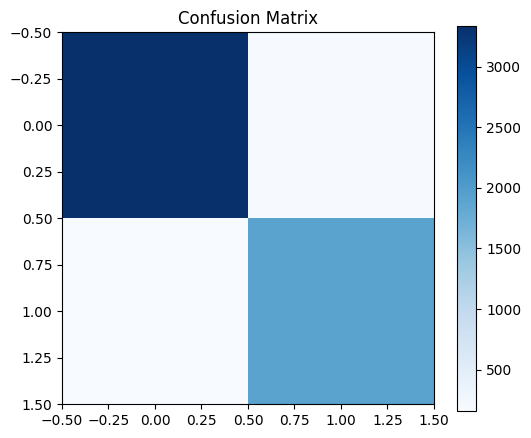

In [3]:
if __name__=="__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--num_epochs', type=int, default=10)
    parser.add_argument('--seed', type=int, default=42)
    parser.add_argument('--dataset', type=str, default='reddit')
    parser.add_argument('--freeze', type=str, choices=['yes','no'], default='yes')
    parser.add_argument('--patience', type=int, default=2, help='Early stopping patience')
    args, unknown = parser.parse_known_args()
    main(args)